In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from numpy import concatenate
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
	
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
inc = read_csv("../data/H3N2-USA-inc-month.csv", header = 0, index_col = 0)
cov = read_csv("../data/H3N2-USA-cov-month-fitness.csv", header = 0, index_col = 0)
# cov = cov[['pop', 'dpop', 'month1', 'month2', 'month3', 'month4', 'month5',
#        'month6', 'H1N', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9',
#        'y10', 'y11', 'y12', 'y13']]
cov = cov[['month1', 'month2', 'month3', 'month4', 'month5',
       'month6', 'H1N', 'y1', 'y2', 'y3', 'y4', 'y5']]
dataset = pd.concat([cov,inc], axis = 1)
dataset = dataset.iloc[3:,]
dataset.head(4)

,month1,month2,month3,month4,month5,month6,H1N,y1,y2,y3,y4,y5,H3N
month,,,,,,,,,,,,,
2003.000000,0.666667,0.166667,0.000000,0.000000e+00,0.0,0.166667,922174,1.252386,1.647591,1.054771,1.017501,0.810224,221326
2003.083333,0.479167,0.479167,0.020833,0.000000e+00,0.0,0.020833,4044901,1.224892,1.624514,1.087051,1.058360,0.844767,1528254
2003.166667,0.166667,0.666667,0.166667,1.567900e-38,0.0,0.000000,1475084,1.141848,1.493192,1.057678,1.053394,0.846697,590119
2003.250000,0.020833,0.479167,0.479167,2.083333e-02,0.0,0.000000,242687,1.073057,1.408356,1.024995,1.033565,0.843297,266967


## What are we trying to predict

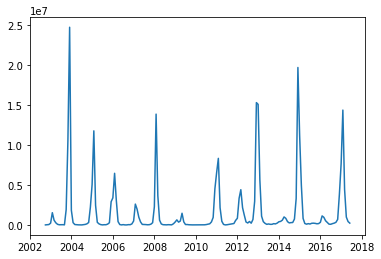

In [4]:
pyplot.plot(inc)

In [25]:
#     num_month = 12
#     
#     n_pred = 1
#     batch_s=12
#     num_epochs=100

def flu_pred(num_month = 12,n_pred = 1,batch_s=12,num_epochs=100, dropout_rate = 0):
    n_features = len(dataset.columns) - 1
    
    values = dataset.values
    # integer encode direction
    values = values.astype('float32')
    # normalize features

    ## use previous "num_month" data points (all features)
    ## to predict the next "n_pred" incidence data

    # frame as supervised learning
    reframed = series_to_supervised(values, num_month, n_pred)
    #reframed.drop(reframed.columns[23:45], axis=1, inplace=True)
    #reframed.drop(reframed.columns[(n_features):-n_pred], axis=1, inplace=True)
    X = reframed[reframed.columns[:num_month*(n_features+1)]]
    y_col = ['var%d(t)' % (n_features+1)] + [('var%d(t+%d)' % (n_features+1, i)) for i in range(1,n_pred)]
    y = reframed[y_col]
    reframed = pd.concat([X,y], axis = 1)
    # ('var%d(t+%d)' % (j+1, i))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(reframed)
    # specify the number of lag hours


    #num_month = 3
    num_pred = n_pred

    values = dataset.values
    # integer encode direction
    values = values.astype('float32')
    # normalize features

    n_month = num_month
    n_features = len(dataset.columns) - 1
    n_pred = num_pred
    # frame as supervised learning
    reframed = series_to_supervised(values, n_month, n_pred)
    #reframed.drop(reframed.columns[23:45], axis=1, inplace=True)
    #reframed.drop(reframed.columns[(n_features):-n_pred], axis=1, inplace=True)
    X = reframed[reframed.columns[:n_month*(n_features+1)]]
    y_col = ['var%d(t)' % (n_features+1)] + [('var%d(t+%d)' % (n_features+1, i)) for i in range(1,n_pred)]
    y = reframed[y_col]
    reframed = pd.concat([X,y], axis = 1)
    # ('var%d(t+%d)' % (j+1, i))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(reframed)
    # specify the number of lag hours

    # split into train and test sets
    #values = reframed.values
    values = scaled

    n_train_month = 12*8
    train = values[:n_train_month, :]
    test = values[n_train_month:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-num_pred], train[:, -num_pred:]
    test_X, test_y = test[:, :-num_pred], test[:, -num_pred:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # design network
    model = Sequential()
    ## note differences : here specifying batch_size not here but in "fit"
    #model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(30))
    model.add(Dense(num_pred))
    model.compile(loss='mae', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_s, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    ## important to note that use test data as validation (of course shuffle=False)
    # validation_data: tuple (x_val, y_val) or tuple (x_val, y_val, val_sample_weights) 
    # on which to evaluate the loss and any model metrics at the end of each epoch. 
    # The model will not be trained on this data. This will override validation_split.

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    # inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    # inv_yhat = concatenate((yhat, test_X), axis=1)
    inv_yhat = concatenate((test_X,yhat), axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    #inv_yhat = inverse_transform(inv_yhat)

    # inv_yhat = inv_yhat[:,:num_pred]
    inv_yhat = inv_yhat[:,-num_pred:]

    #inv_yhat = inv_yhat[0,:]

    # invert scaling for actual
    #test_y = test_y.reshape((len(test_y), 1))
    #inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    # inv_y = concatenate((test_y, test_X), axis=1)
    inv_y = concatenate((test_X,test_y), axis=1)

    inv_y = scaler.inverse_transform(inv_y)
    # inv_y = inv_y[:,:num_pred]
    inv_y = inv_y[:,-num_pred:]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)

    # #pyplot.plot(inv_y[1,:])
    # #pyplot.plot(inv_yhat[1,:])

    # for i in range(61):
    #     pyplot.plot(inv_y[i,:])
    #     pyplot.plot(inv_yhat[i,:])
    #     pyplot.show()

    # for i in range(num_pred):
    #     pyplot.plot(inv_y[:,i])
    #     pyplot.plot(inv_yhat[:,i])
    #     pyplot.show()

    # make a prediction
    yhat_t = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    # invert scaling for forecast
    # inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    # inv_yhat = concatenate((yhat, test_X), axis=1)
    inv_yhat_t = concatenate((train_X,yhat_t), axis=1)

    inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
    #inv_yhat = inverse_transform(inv_yhat)

    # inv_yhat = inv_yhat[:,:num_pred]
    inv_yhat_t = inv_yhat_t[:,-num_pred:]

    #inv_yhat = inv_yhat[0,:]

    # invert scaling for actual
    #test_y = test_y.reshape((len(test_y), 1))
    #inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    # inv_y = concatenate((test_y, test_X), axis=1)
    inv_y_t = concatenate((train_X,train_y), axis=1)

    inv_y_t = scaler.inverse_transform(inv_y_t)
    # inv_y = inv_y[:,:num_pred]
    inv_y_t = inv_y_t[:,-num_pred:]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y_t, inv_yhat_t))
    print('Train RMSE: %.3f' % rmse)

    #pyplot.plot(inv_y[1,:])
    #pyplot.plot(inv_yhat[1,:])

    # for i in range(61):
    #     pyplot.plot(inv_y_t[i,:])
    #     pyplot.plot(inv_yhat_t[i,:])
    #     pyplot.show()

    # for i in range(num_pred):
    #     pyplot.plot(inv_y_t[:,i])
    #     pyplot.plot(inv_yhat_t[:,i])
    #     pyplot.show()
    return(inv_y_t, inv_yhat_t, inv_y, inv_yhat)

(96, 1, 156) (96, 1) (66, 1, 156) (66, 1)


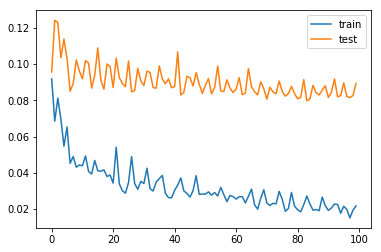

Test RMSE: 3645047.666
Train RMSE: 1023389.792


In [12]:
(inv_y_t, inv_yhat_t, inv_y, inv_yhat) = flu_pred()

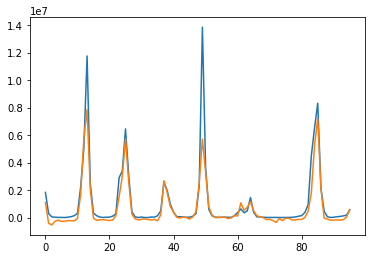

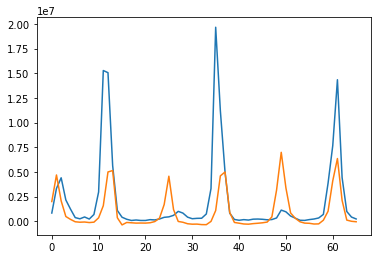

In [13]:
for i in range(n_pred):
    pyplot.plot(inv_y_t[:,i])
    pyplot.plot(inv_yhat_t[:,i])
    pyplot.show()
    
for i in range(num_pred):
    pyplot.plot(inv_y[:,i])
    pyplot.plot(inv_yhat[:,i])
    pyplot.show()

## Comment:
Look promising. See what it can do with more epochs.

(96, 1, 156) (96, 1) (66, 1, 156) (66, 1)


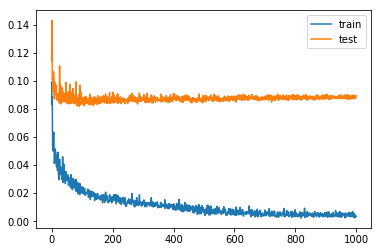

Test RMSE: 3766985.862
Train RMSE: 80892.124


In [14]:
(inv_y_t, inv_yhat_t, inv_y, inv_yhat) = flu_pred(num_epochs=1000)

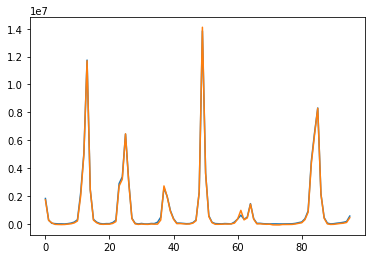

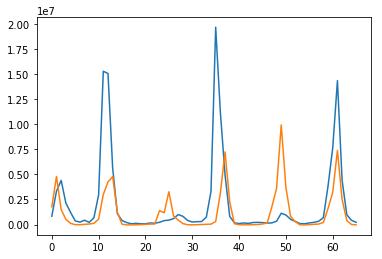

In [15]:
for i in range(n_pred):
    pyplot.plot(inv_y_t[:,i])
    pyplot.plot(inv_yhat_t[:,i])
    pyplot.show()
    
for i in range(num_pred):
    pyplot.plot(inv_y[:,i])
    pyplot.plot(inv_yhat[:,i])
    pyplot.show()

## Comment:
There might be an issue of overfitting, as training is much better than test group. But anyway, it seems to be able to capture the seasonality. There is room for improvement. Let's see how it does when predicting more months to the future.

(96, 1, 156) (96, 12) (55, 1, 156) (55, 12)


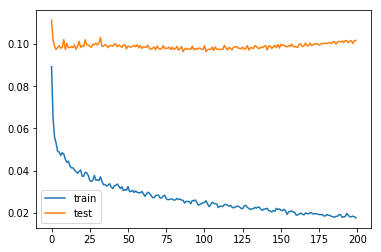

Test RMSE: 4160813.445
Train RMSE: 1039260.000


In [16]:
(inv_y_t, inv_yhat_t, inv_y, inv_yhat) = flu_pred(num_epochs=200, n_pred=12)

training


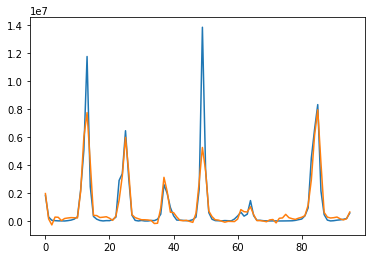

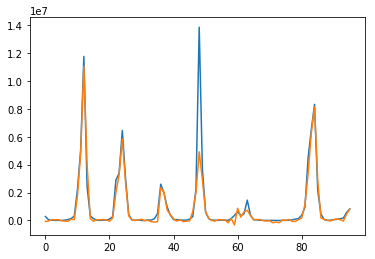

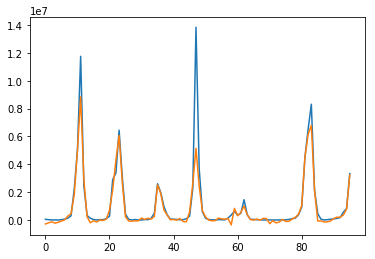

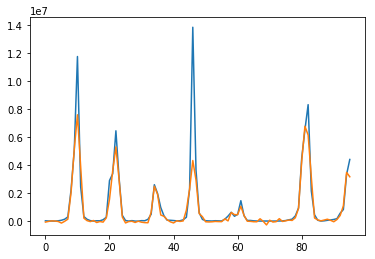

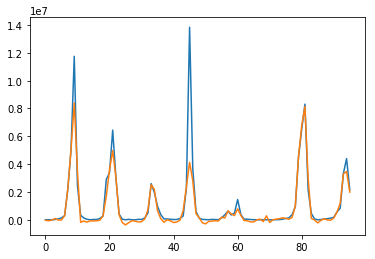

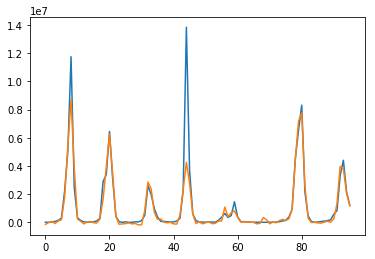

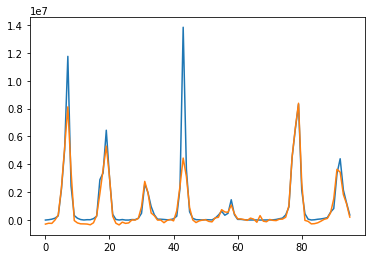

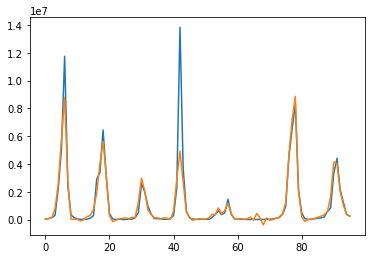

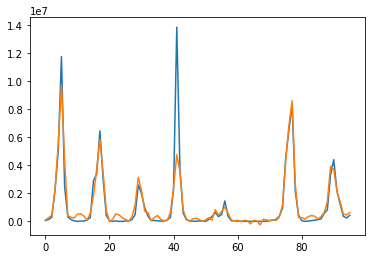

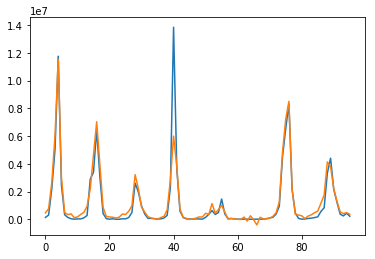

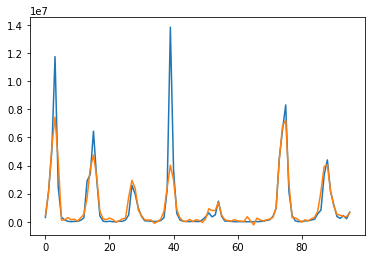

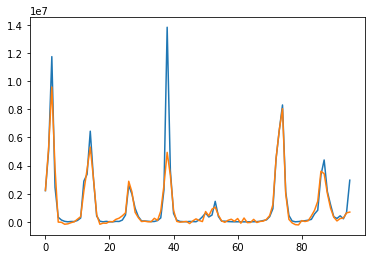

In [20]:
n_pred = 12
print("training")
for i in range(n_pred):
    pyplot.plot(inv_y_t[:,i])
    pyplot.plot(inv_yhat_t[:,i])
    pyplot.show()
    

testing


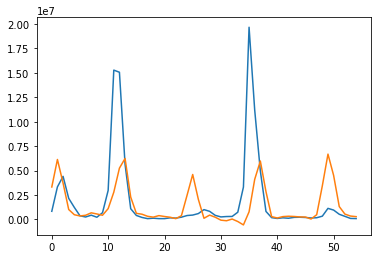

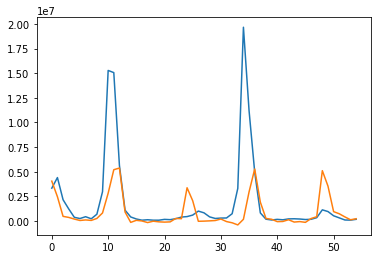

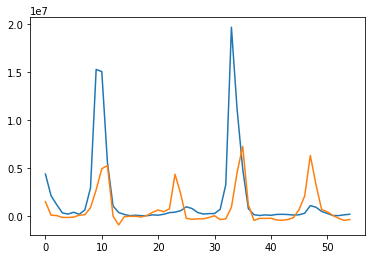

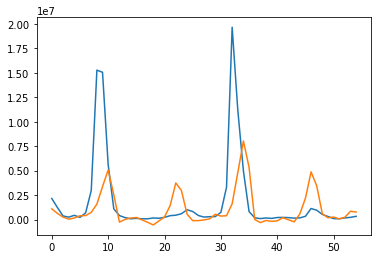

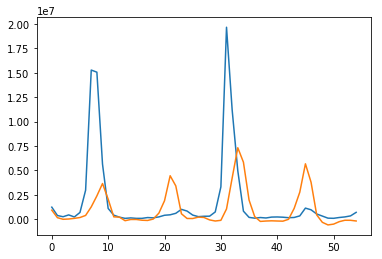

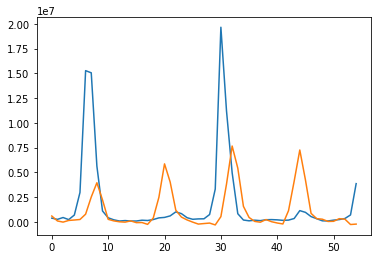

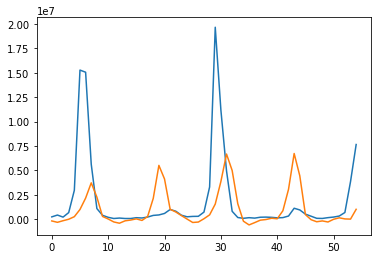

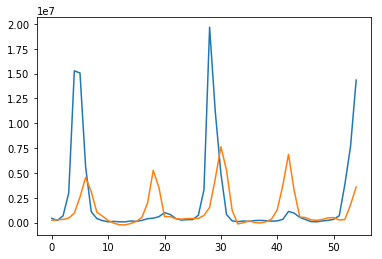

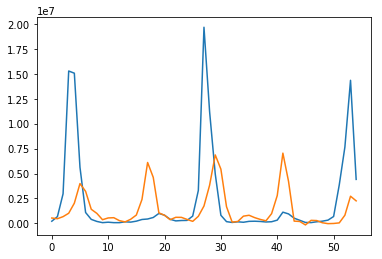

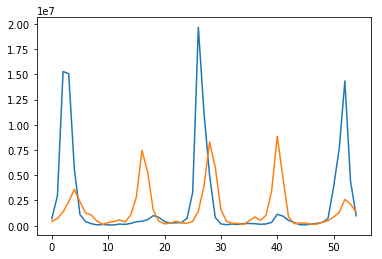

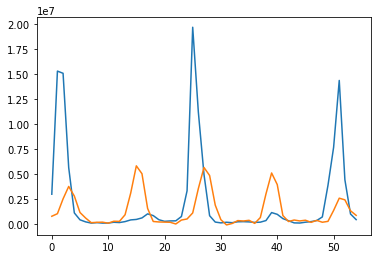

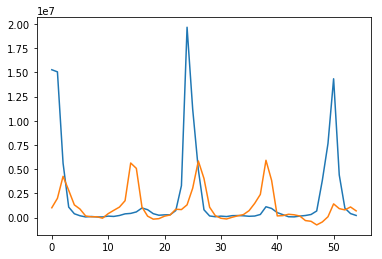

In [21]:
print("testing")
for i in range(n_pred):
    pyplot.plot(inv_y[:,i])
    pyplot.plot(inv_yhat[:,i])
    pyplot.show()

In [22]:
inv_y.shape

(55, 12)

### See ther performance of all the 12-month predictions

training


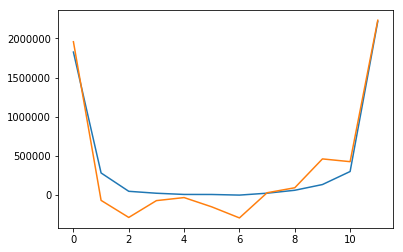

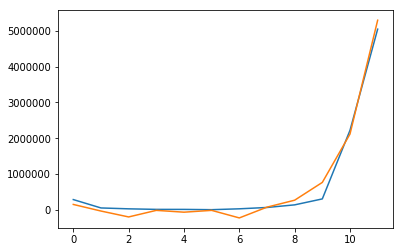

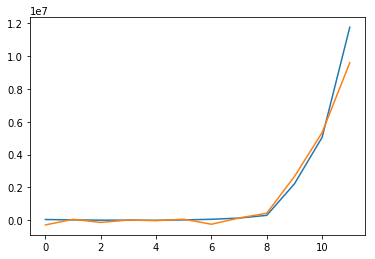

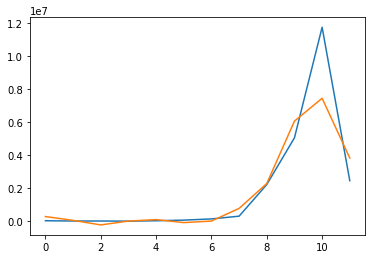

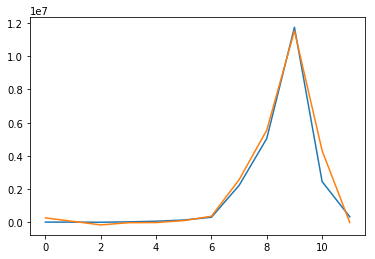

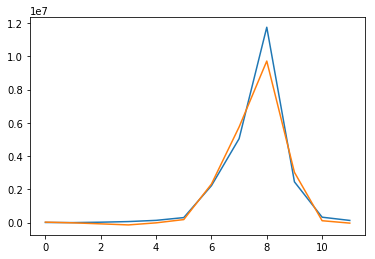

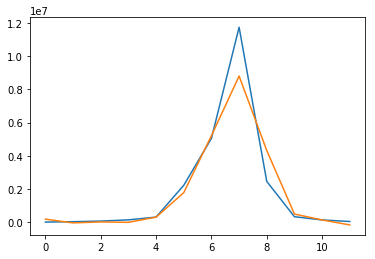

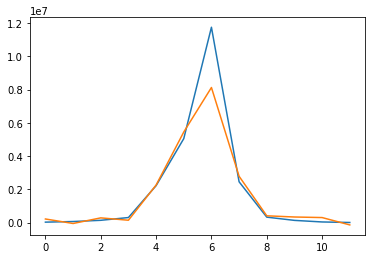

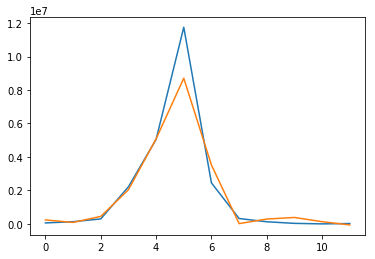

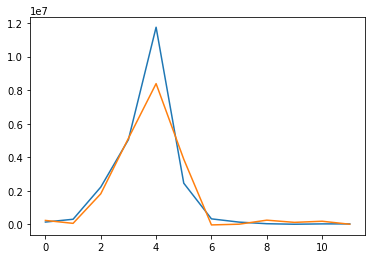

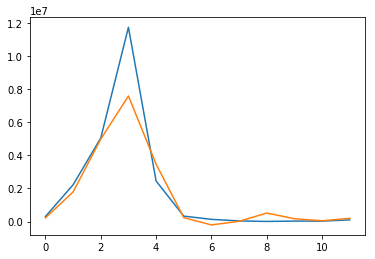

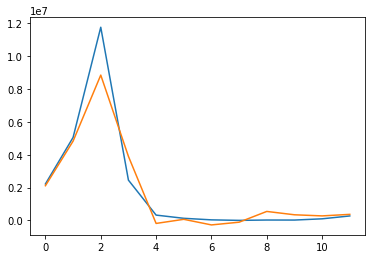

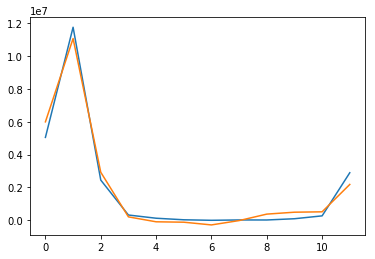

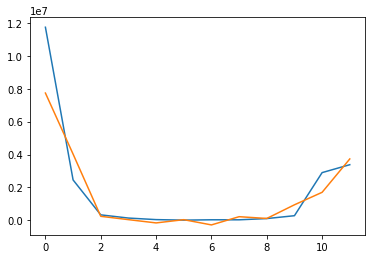

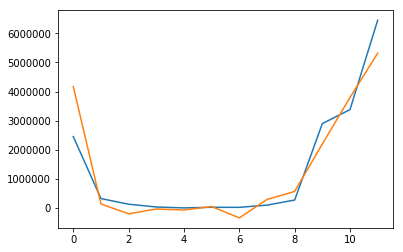

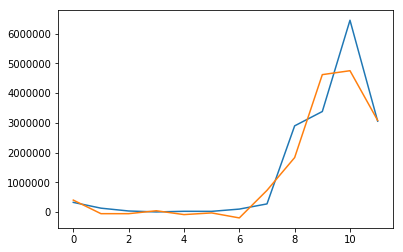

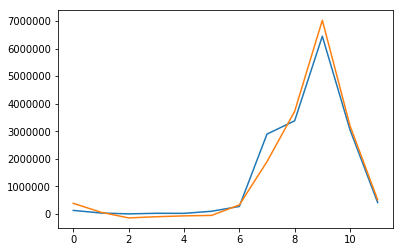

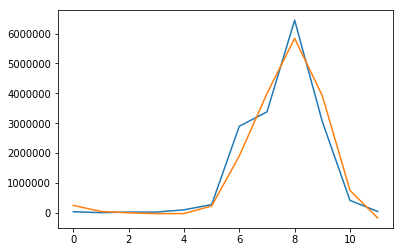

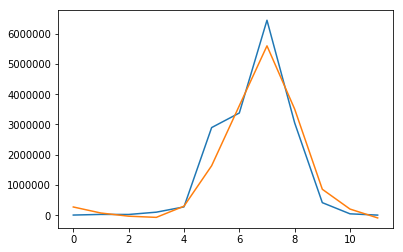

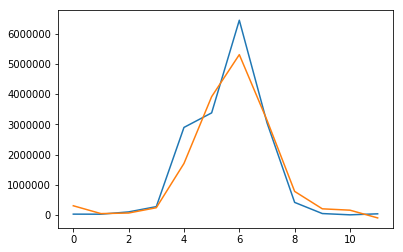

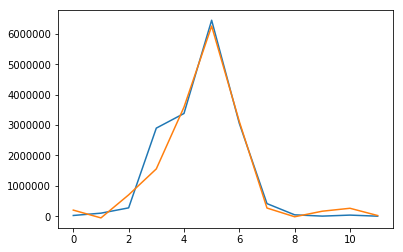

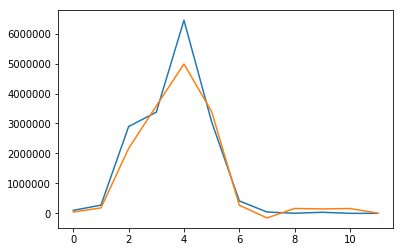

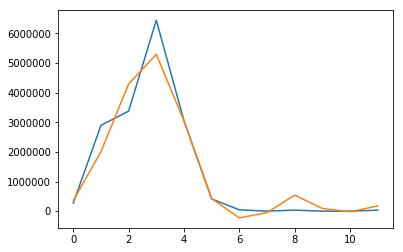

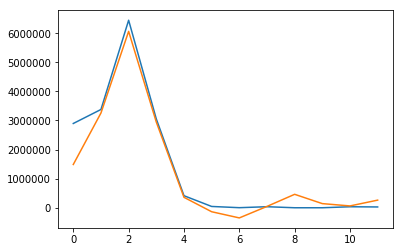

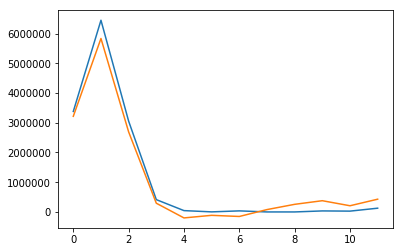

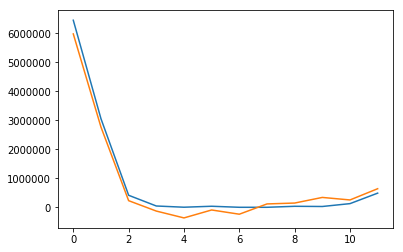

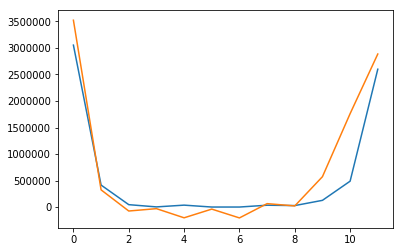

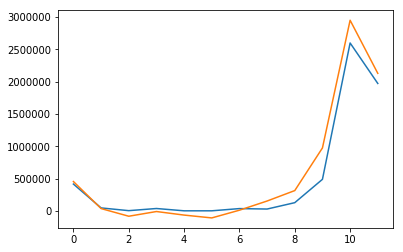

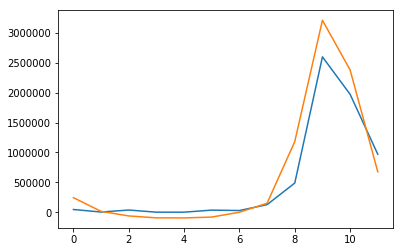

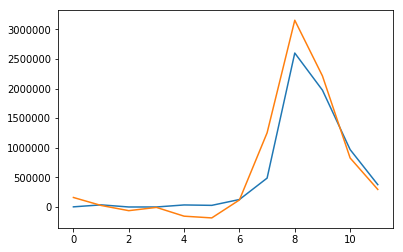

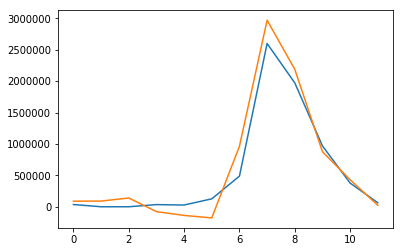

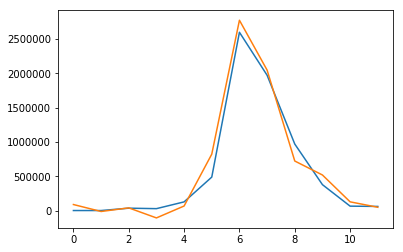

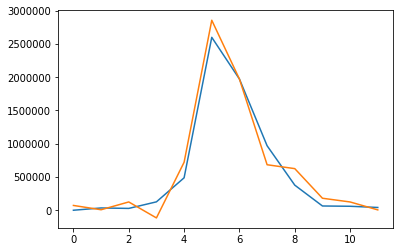

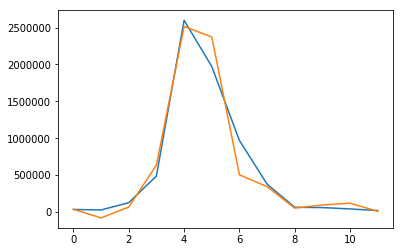

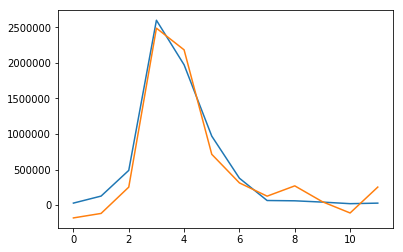

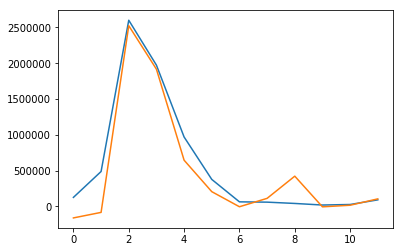

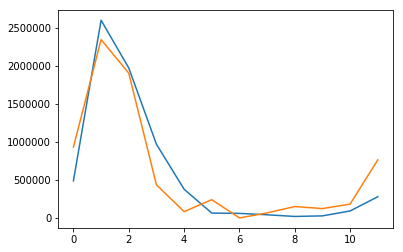

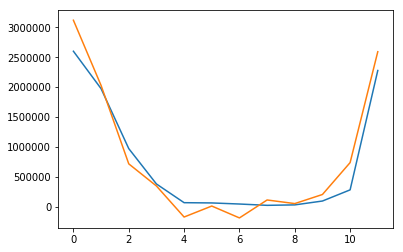

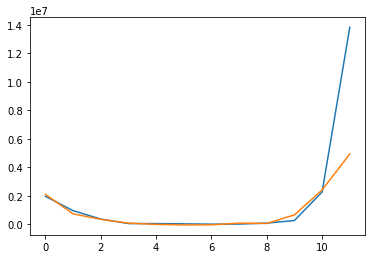

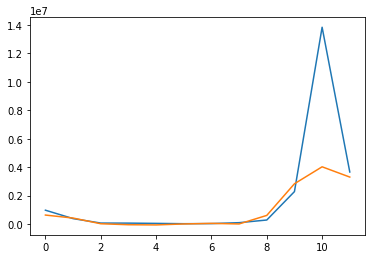

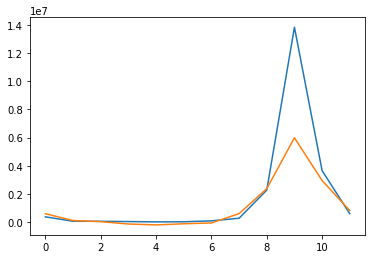

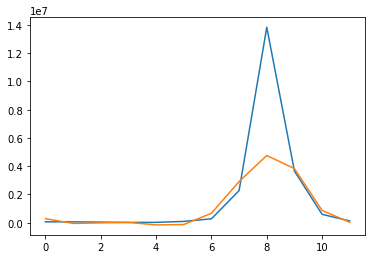

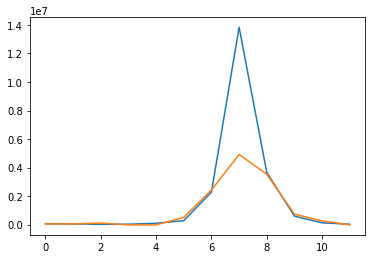

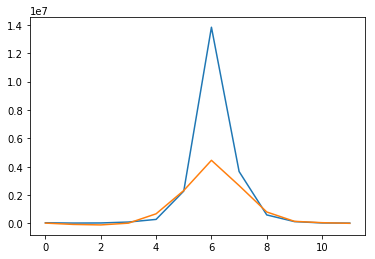

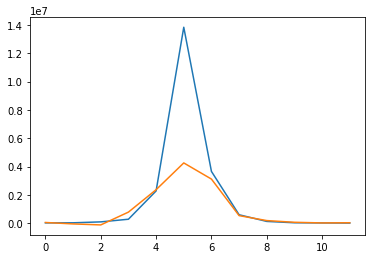

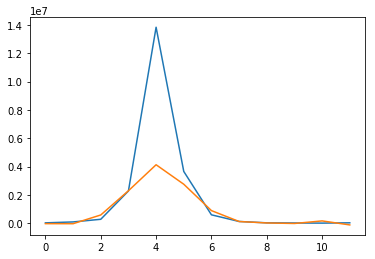

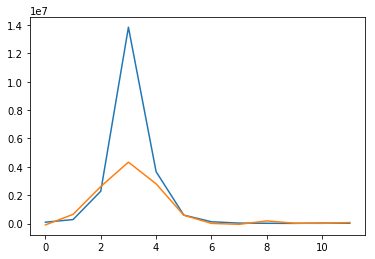

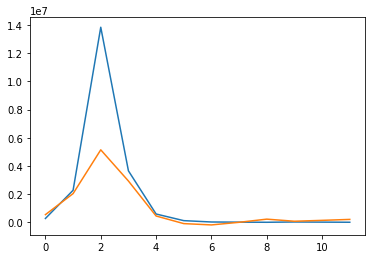

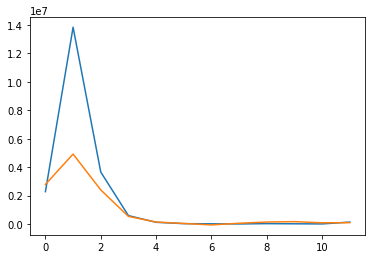

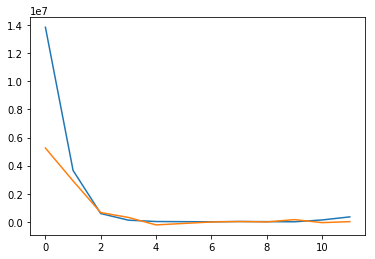

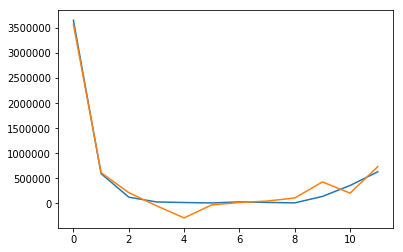

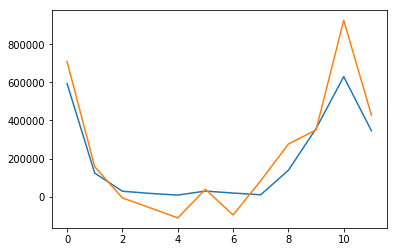

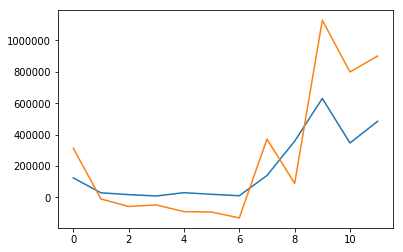

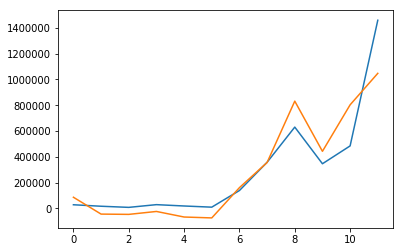

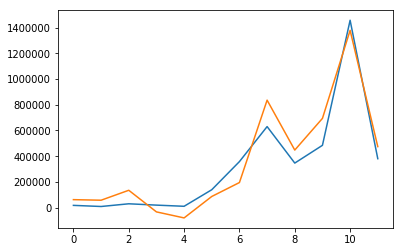

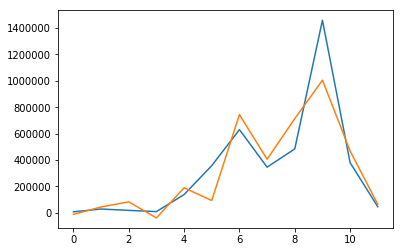

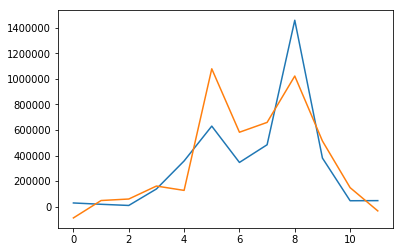

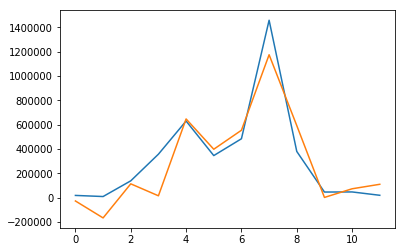

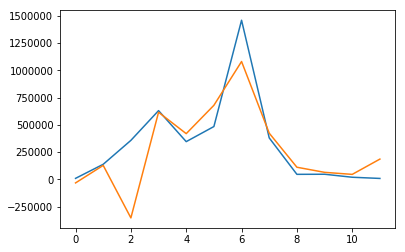

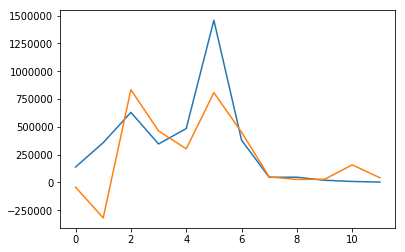

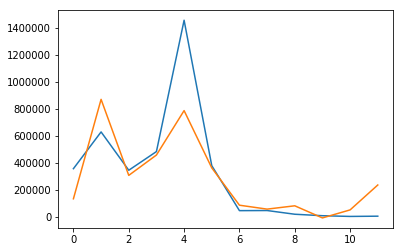

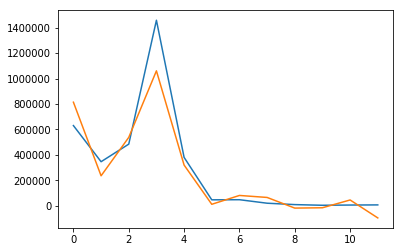

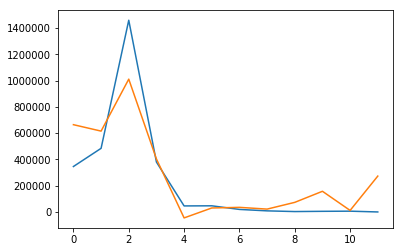

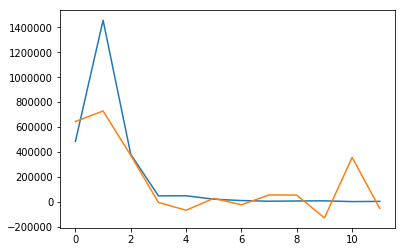

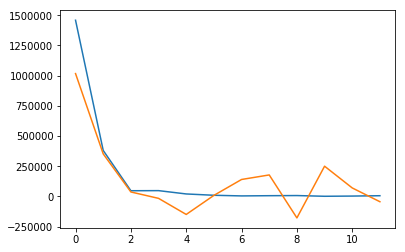

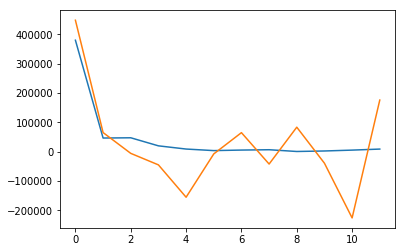

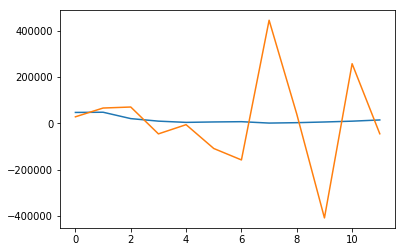

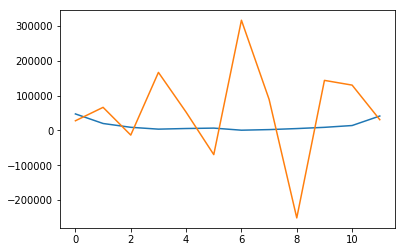

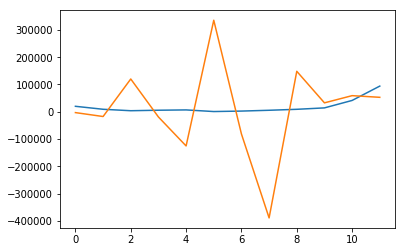

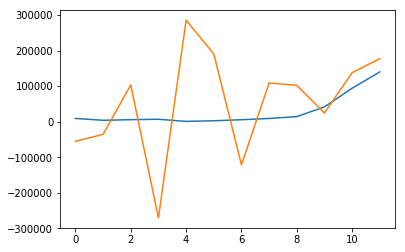

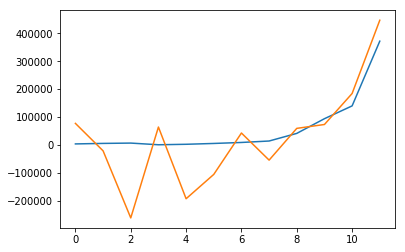

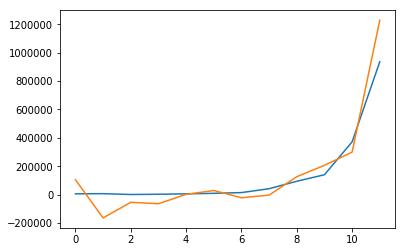

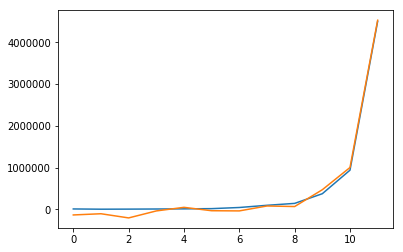

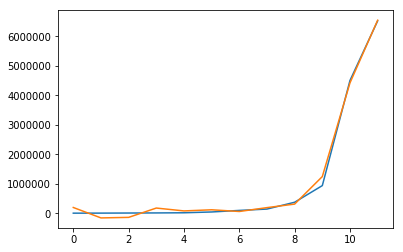

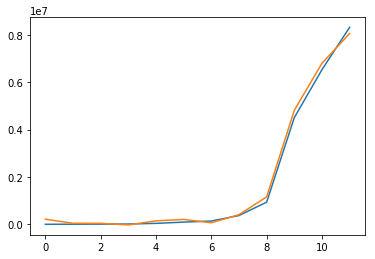

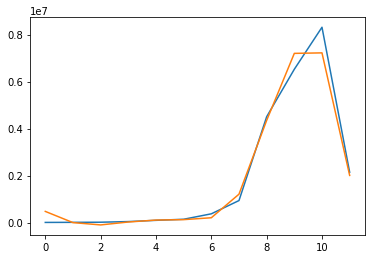

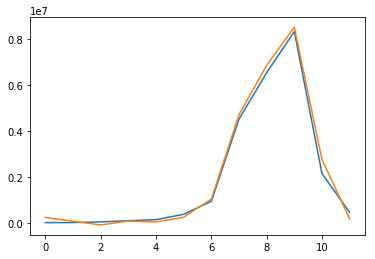

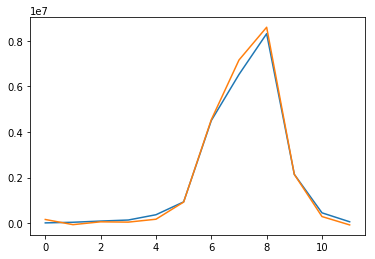

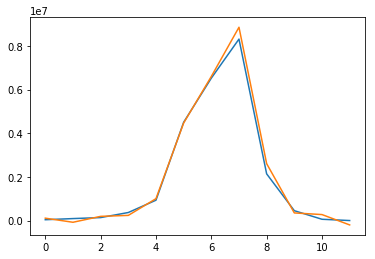

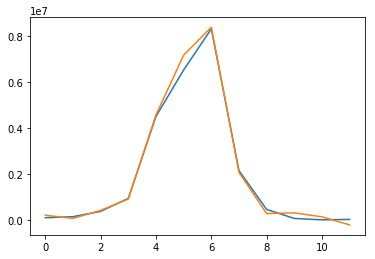

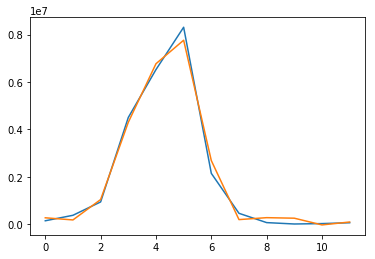

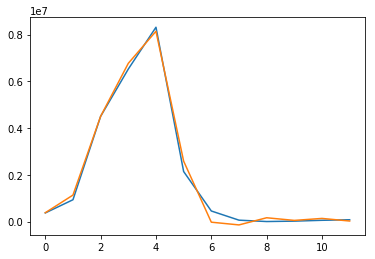

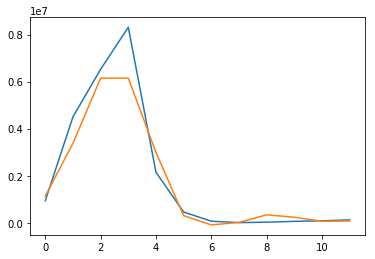

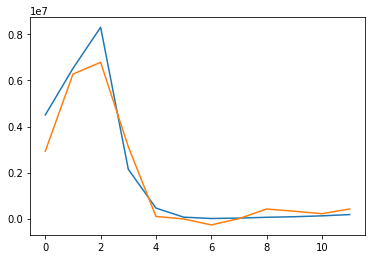

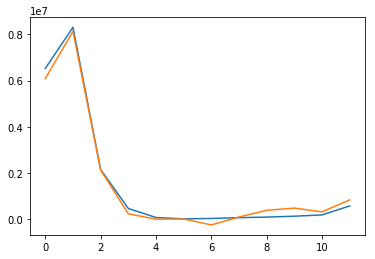

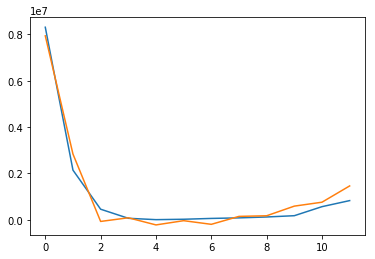

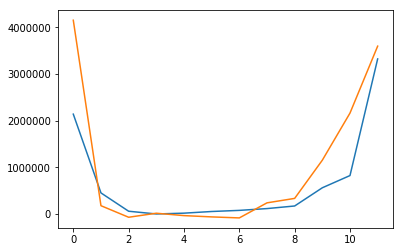

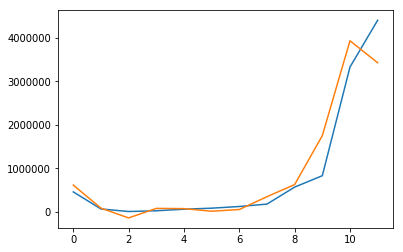

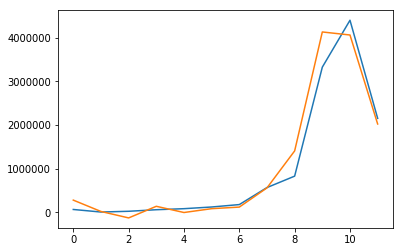

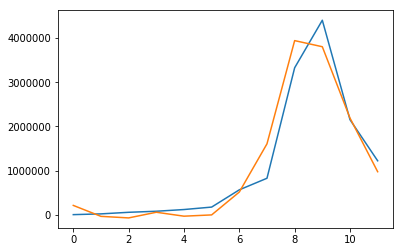

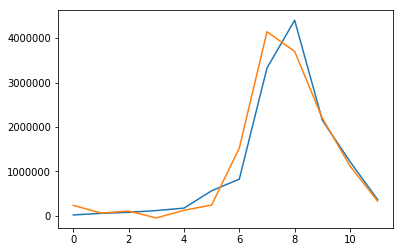

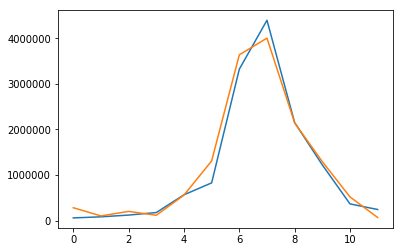

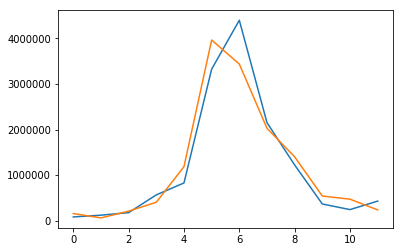

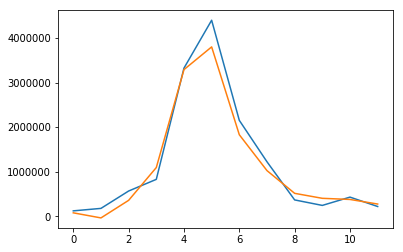

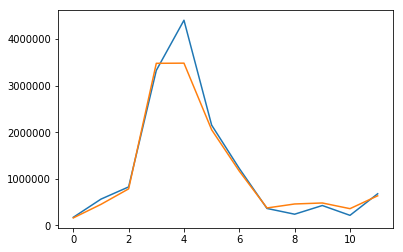

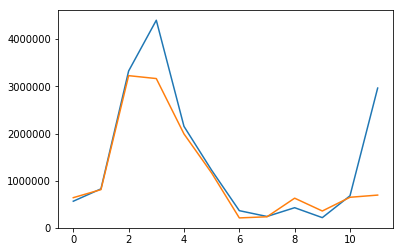

In [24]:
print("training")
for i in range(inv_y_t.shape[0]):
    pyplot.plot(inv_y_t[i,:])
    pyplot.plot(inv_yhat_t[i,:])
    pyplot.show()

testing


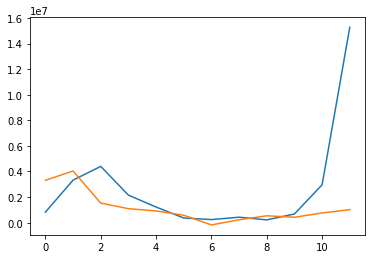

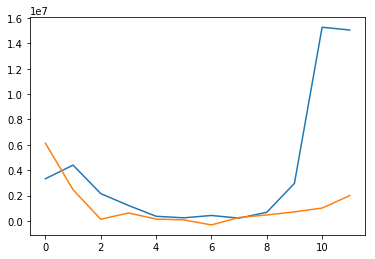

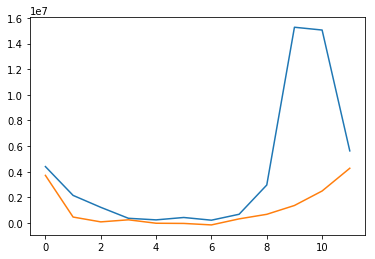

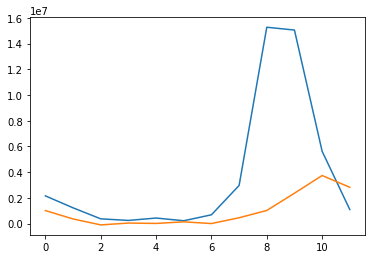

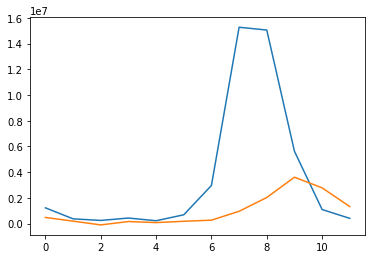

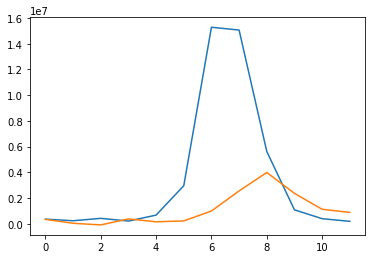

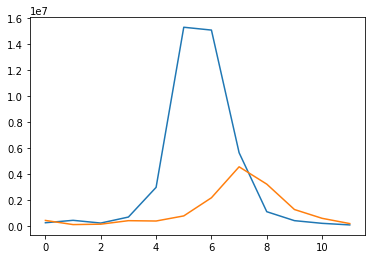

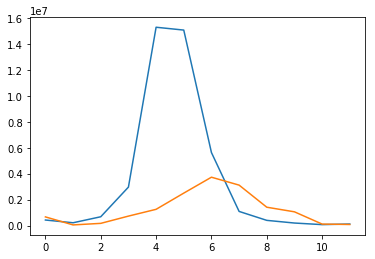

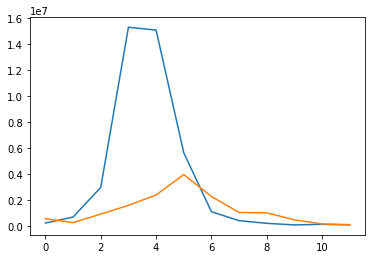

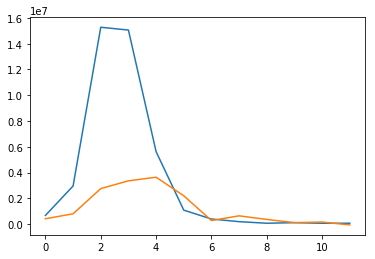

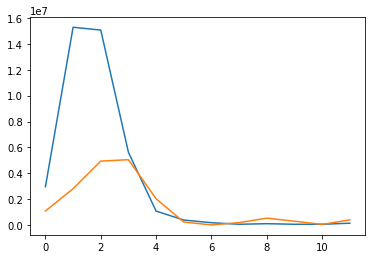

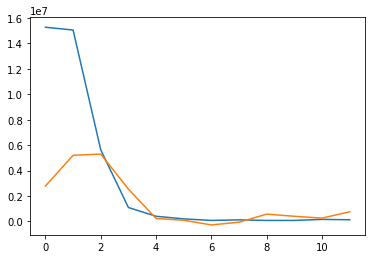

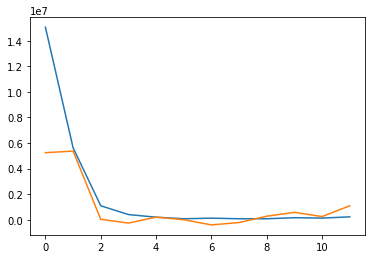

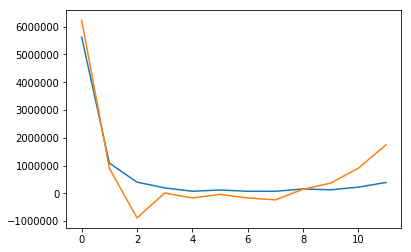

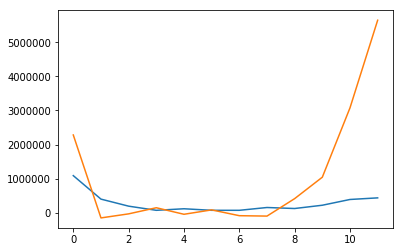

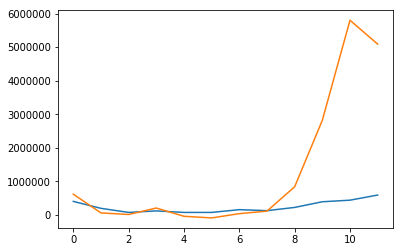

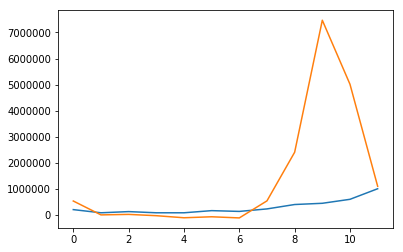

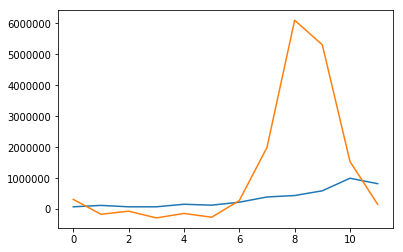

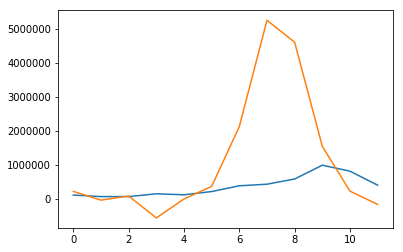

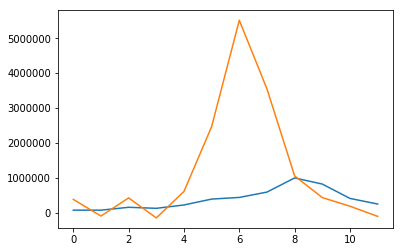

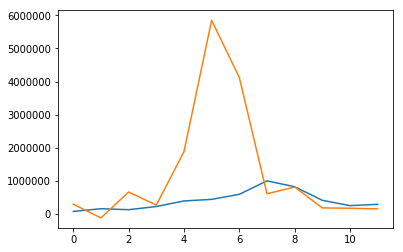

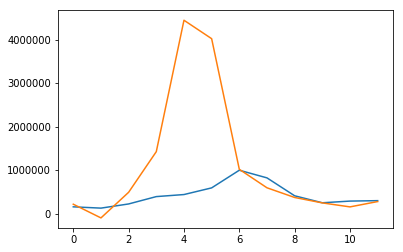

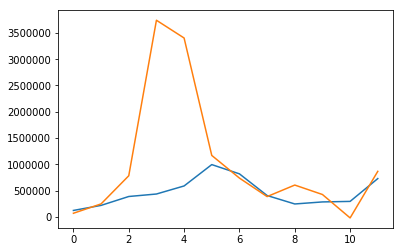

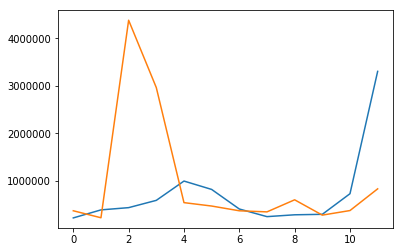

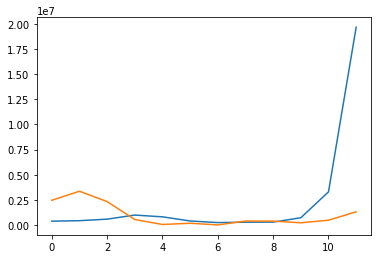

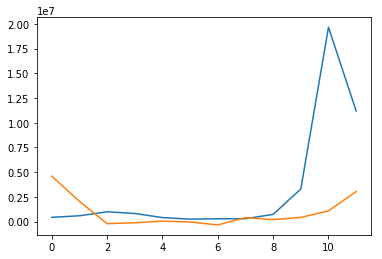

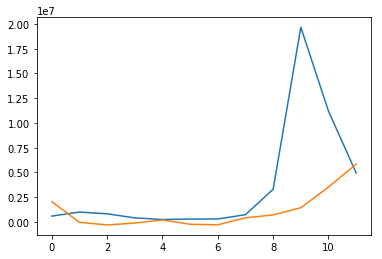

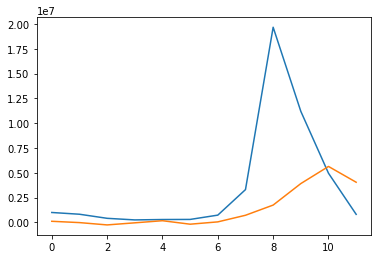

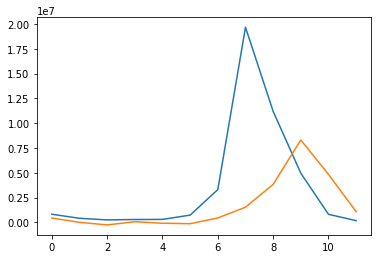

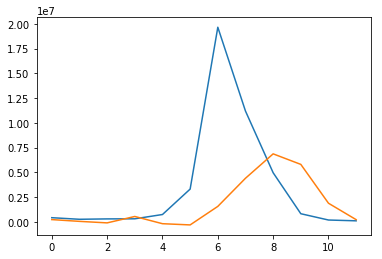

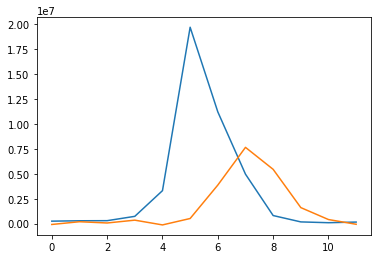

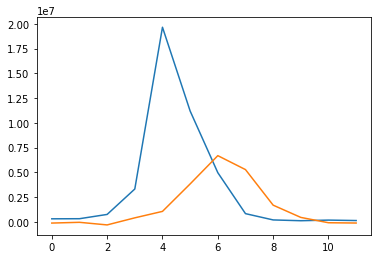

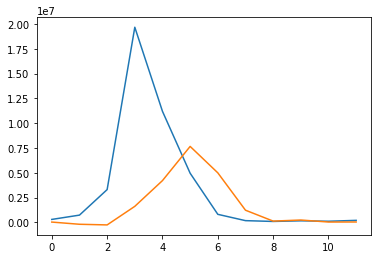

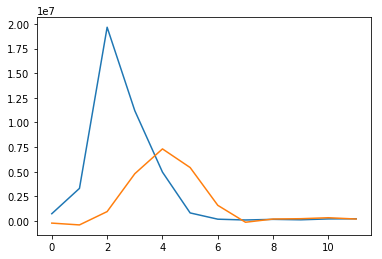

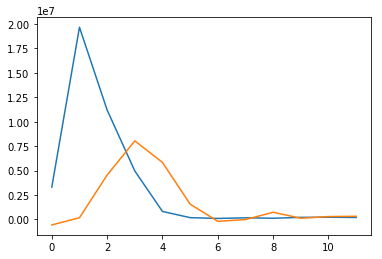

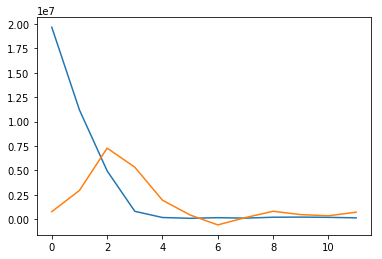

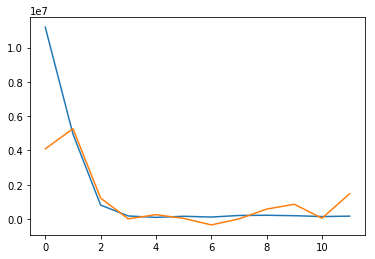

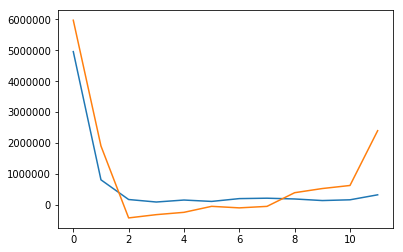

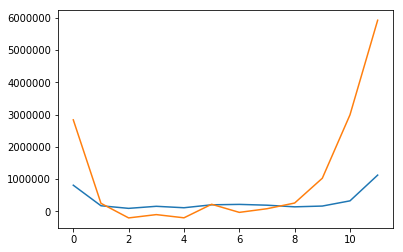

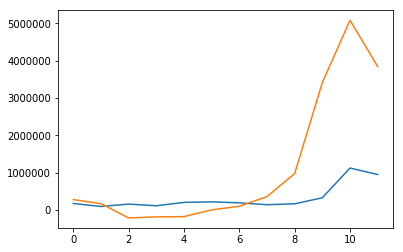

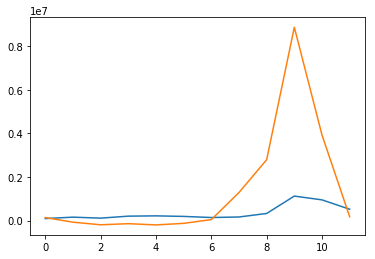

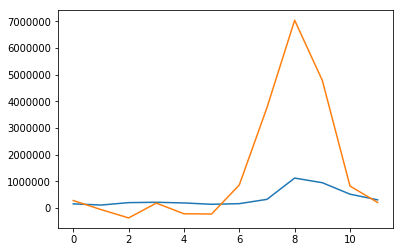

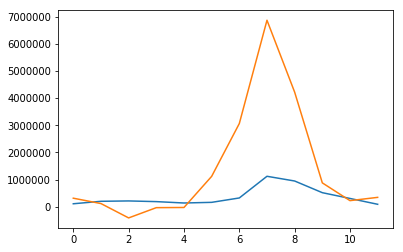

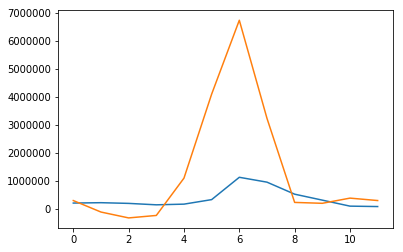

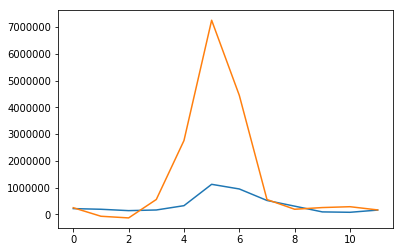

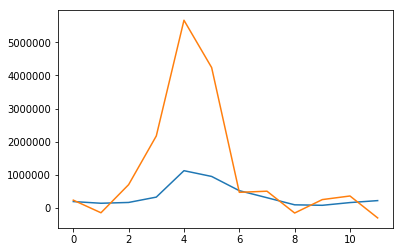

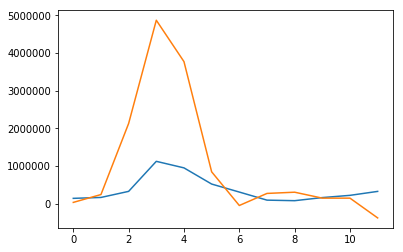

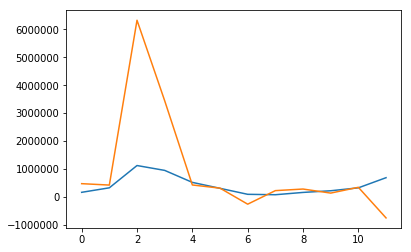

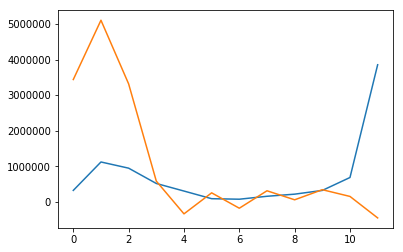

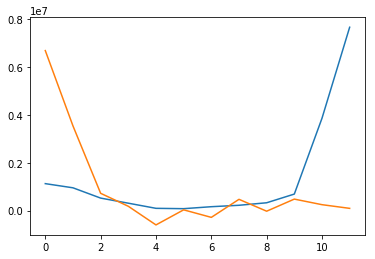

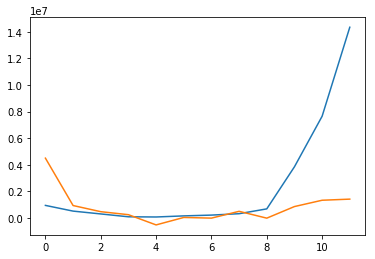

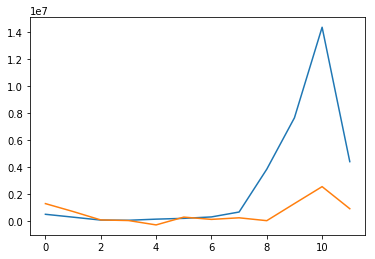

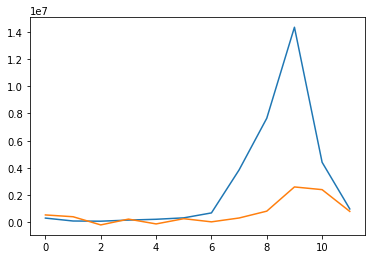

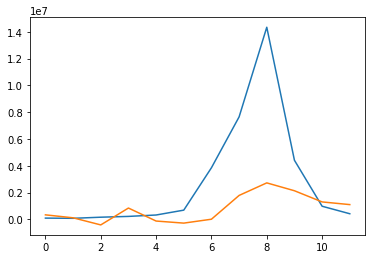

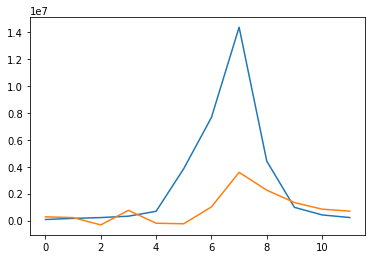

In [23]:
print("testing")
for i in range(inv_y.shape[0]):
    pyplot.plot(inv_y[i,:])
    pyplot.plot(inv_yhat[i,:])
    pyplot.show()

## predict 6 points 

## Try Dropout to fight overfit

(96, 1, 156) (96, 1) (66, 1, 156) (66, 1)


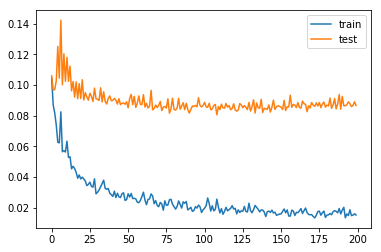

Test RMSE: 3637992.493
Train RMSE: 713252.658


In [26]:
(inv_y_t, inv_yhat_t, inv_y, inv_yhat) = flu_pred(num_epochs=200, n_pred=1, dropout_rate=0.2)

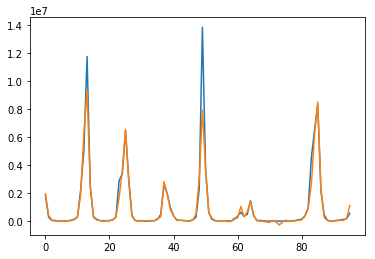

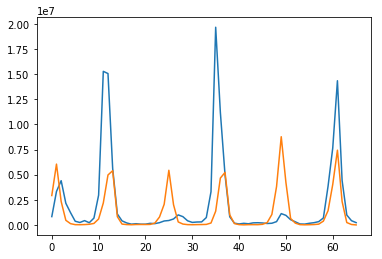

In [27]:
n_pred = 1
for i in range(n_pred):
    pyplot.plot(inv_y_t[:,i])
    pyplot.plot(inv_yhat_t[:,i])
    pyplot.show()
    
for i in range(n_pred):
    pyplot.plot(inv_y[:,i])
    pyplot.plot(inv_yhat[:,i])
    pyplot.show()

## Comment:
Does not seem to improve. Might try add another dropout at the second layer...

## Improvement:
Might need to find better features, like the data from the same month previous years, autocorrelation...